In [2]:
from __future__ import print_function
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import poisson

%matplotlib inline  

# Boils down to "If I pick hosts 2 * (rf - 1) * vnode times, how many
# distinct hosts will I have in expectation". Note that this is a slightly
# optimistic estimate because Cassandra won't place two replicas of the
# same token on the same machine or rack, but this is close enough for
# the model
# This is a variant of the Birthday Problem where we are interested
# in the number of distinct values produced
# http://www.randomservices.org/random/urn/Birthday.html
def num_neighbors(n, v, rf, strategy="rack"):
    k = 2 * v * (rf - 1)
    if strategy == "rack":
        # As cassandra is rack aware, we assume #racks == #replicas
        # This is maybe a bad assumption for some datacenter deployments
        n = n - (n // rf)
    else:
        # SimpleStrategy
        n = n - 1
    estimate = (n * (1.0 - (1.0 - 1.0/n) ** k))
    return max(rf - 1, min(estimate, n))

def p_outage_given_failure(recovery_seconds, num_neighbors, rate_in_seconds):
    x = math.exp(-1 * recovery_seconds * num_neighbors * rate_in_seconds)
    return 1 - x

def global_rate(node_rate, nodes, split_probability):
    return node_rate * nodes * split_probability

def recovery_seconds(size, bw_in, bw_out, neighbors):
    return int(size / (min(bw_in, neighbors * bw_out)))

# Default model
nodes = 96
vnodes = 256
rf = 3
# 1000 gigabytes
node_dataset_mb = 300 * 1024
# MB/s
bw_in = 125
# MB/s, cassandra.yaml has 25MBPS as the default
# but most operators observe maybe half of that 
bw_out = 25 / 2
strategy = 'rack'

year_seconds = 60.0*60*24*365
century_seconds = 100 * year_seconds

# Model machines that fail on average 
# 25 times per century a.k.a 1 in 4 machines
# fails per year, or a machine fails every
# 4 years
arate = 25
arate_in_seconds = 25 / century_seconds


print("\nFailure Rate Variability")
print("Neighbors for {0} vnodes: {1:.3f}".format(1, num_neighbors(nodes, 1, rf)))
print("Neighbors for {0} vnodes: {1:.3f}".format(4, num_neighbors(nodes, 4, rf)))
print("Neighbors for {0} vnodes: {1:.3f}".format(16, num_neighbors(nodes, 16, rf)))

aneighbors = num_neighbors(nodes, vnodes, rf)
arecovery = recovery_seconds(node_dataset_mb, bw_in, bw_out, aneighbors)
print("Neighbors for {0} vnodes: {1:.3f}".format(vnodes, aneighbors))


def outage_stats(vnodes, failure_rate_per_century, num_nodes, rf, bw_in, bw_out, strategy='rack'):
    neighbors = num_neighbors(num_nodes, vnodes, rf, strategy)
    recovery_s = recovery_seconds(node_dataset_mb, bw_in, bw_out, neighbors)
    p_failure = p_outage_given_failure(
        recovery_s, neighbors, failure_rate_per_century / century_seconds)
    
    lmb = global_rate(failure_rate_per_century, num_nodes, p_failure)
    return (poisson.mean(lmb), poisson.interval(0.50, lmb), poisson.median(lmb))

# Returns outages _per century_
def compute_outage(vnodes, failure_rate_per_century, num_nodes, rf, bw_in, bw_out, strategy='rack'):
    return outage_stats(
        vnodes, failure_rate_per_century, num_nodes, rf, bw_in, bw_out, strategy
    )[0]

print("{0:<6} {1:<8} {2:<8} {3:<8} -> {4:<6}".format(
    "rate", "rec_s", "p_fail", "g_lmb", "outages"
))
for rate in (12.5, 25, 50, 100, 200):
    recovery_s = recovery_seconds(node_dataset_mb, bw_in, bw_out, aneighbors)
    p_failure = p_outage_given_failure(
        recovery_s, aneighbors, rate / century_seconds)
    gl = global_rate(rate, nodes, p_failure)
    p = "{0:6.2f} {1:6.2f} {2:8.6f} {3:8.4f} -> {4:6.6f}".format(
        rate, recovery_s, p_failure, gl, poisson.mean(gl)
    )
    print(p)



Failure Rate Variability
Neighbors for 1 vnodes: 3.907
Neighbors for 4 vnodes: 14.255
Neighbors for 16 vnodes: 40.641
Neighbors for 256 vnodes: 64.000
rate   rec_s    p_fail   g_lmb    -> outages
 12.50 2457.00 0.000623   0.7477 -> 0.747712
 25.00 2457.00 0.001246   2.9899 -> 2.989917
 50.00 2457.00 0.002490  11.9522 -> 11.952217
100.00 2457.00 0.004974  47.7493 -> 47.749343
200.00 2457.00 0.009923 190.5224 -> 190.522373


[0.11687275130238817, 0.11685442306346161, 0.1287871379552552]
[0.46746823980958752, 0.46739493399350351, 0.51512090827623425]
[1.05175232074739, 1.051587398724152, 1.1589598500957976]
[1.8696908537753743, 1.8693976876205554, 2.06026250847966]


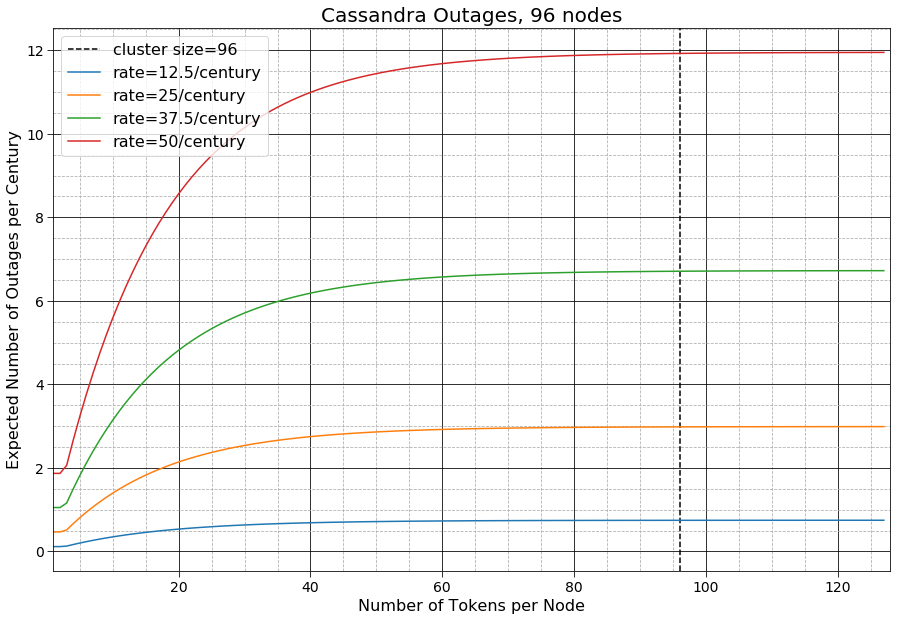

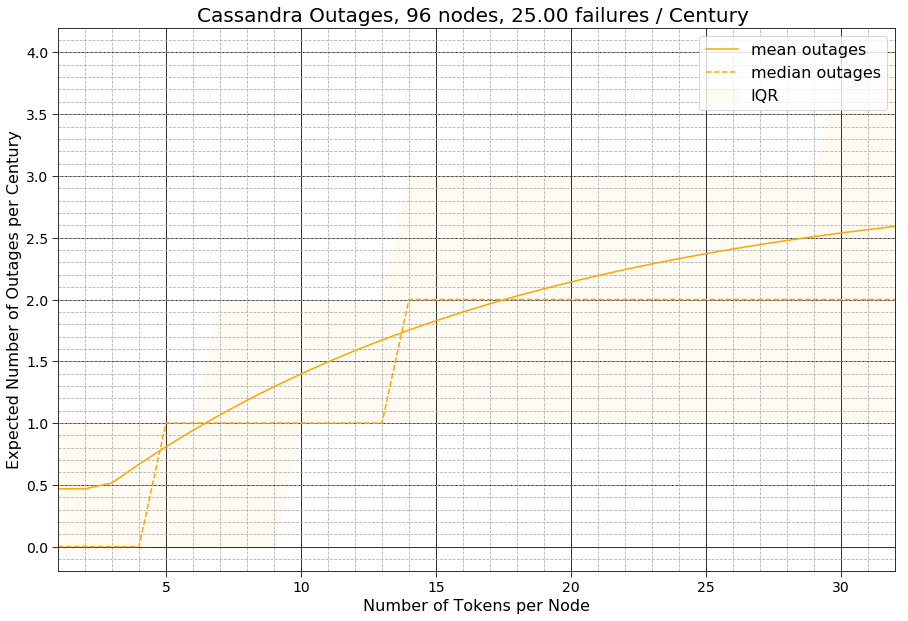

In [3]:
plt.figure(figsize=(15,10))
plt.title("Cassandra Outages, {0} nodes".format(nodes), fontsize=20)
plt.ylabel("Expected Number of Outages per Century", fontsize=16)
plt.xlabel("Number of Tokens per Node", fontsize=16)
plt.xlim(1, 128)
plt.axvline(x=96, color='k', linestyle='--', label='cluster size={0}'.format(nodes))
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)

num_vnodes = range(1, 128)
rates = [12.5, 25, 37.5, 50]
for rate in rates:
    outages = []
    for vnode in num_vnodes:
        outages.append(compute_outage(vnode, rate, nodes, rf, bw_in, bw_out))
    print(outages[:3])
    plt.plot(num_vnodes, outages, label="rate={0}/century".format(rate))
plt.legend(fontsize=16)

outages = [outage_stats(v, arate, nodes, rf, bw_in, bw_out) for v in num_vnodes[:32]]
outage_mean = [o[0] for o in outages]
outage_lower = [o[1][0] for o in outages]
outage_upper = [o[1][1] for o in outages]
outage_median = [o[2] for o in outages]

plt.figure(figsize=(15,10))
plt.title(
    "Cassandra Outages, {0} nodes, {1:.2f} failures / Century ".format(
        nodes, arate), fontsize=20)
plt.ylabel("Expected Number of Outages per Century", fontsize=16)
plt.xlabel("Number of Tokens per Node", fontsize=16)
plt.xlim(1, 32)
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)
plt.plot(num_vnodes[:32], outage_mean, color='orange', label='mean outages')
plt.plot(num_vnodes[:32], outage_median, color='orange', label='median outages', linestyle='--')
plt.fill_between(num_vnodes[:32], outage_lower, outage_upper, color='orange', alpha=0.05, label='IQR')
plt.legend(fontsize=16)


1 [0.014610448859836422, 0.019479659113408321, 0.02434859634069253]
4 [0.014610448859836422, 0.019479433162095106, 0.02434995460075251]
16 [0.014610448859836422, 0.019480598479670874, 0.024350747854035015]
64 [0.014610448859836422, 0.019480598479781897, 0.024350748099727371]
128 [0.014610448859836422, 0.019480598479781897, 0.024350748099727371]


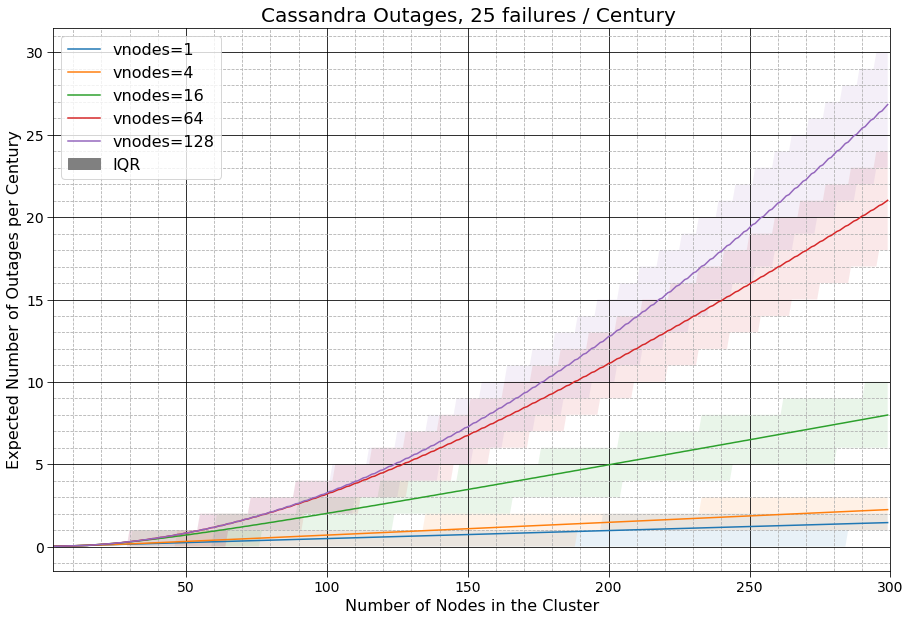

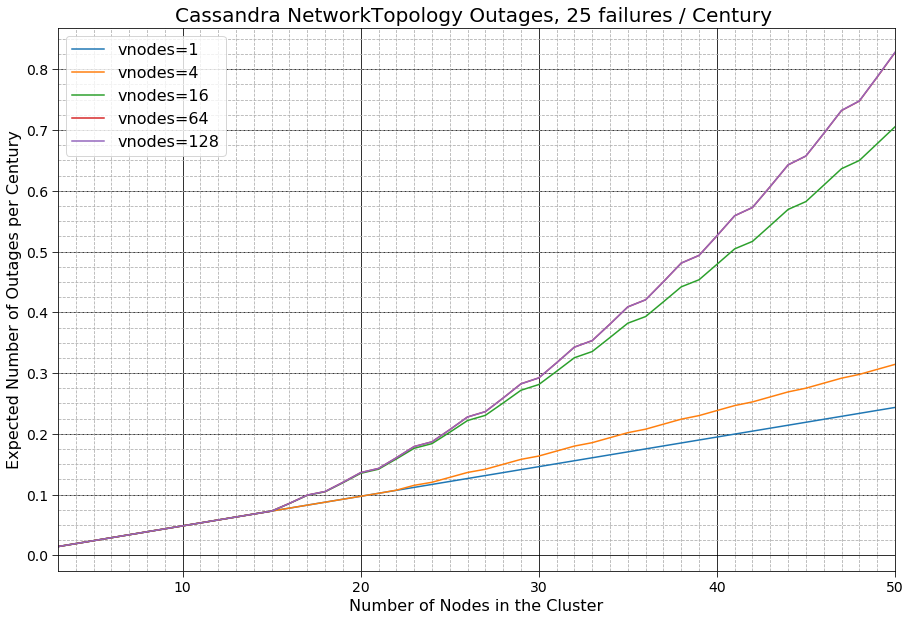

In [8]:
# Hold failures constant, vary size of cluster
plt.figure(figsize=(15,10))
plt.title(
    "Cassandra Outages, {1} failures / Century ".format(
        vnodes, arate), fontsize=20)
plt.ylabel("Expected Number of Outages per Century", fontsize=16)
plt.xlabel("Number of Nodes in the Cluster", fontsize=16)
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)

num_vnodes = (1, 4, 16, 64, 128)
num_nodes = range(3, 300)
lines = []
fills = []
for v in num_vnodes:
    outages = [outage_stats(v, arate, n, rf, bw_in, bw_out) for n in num_nodes]
    outages = [outage_stats(v, arate, n, rf, bw_in, bw_out) for n in num_nodes]
    outage_mean = [o[0] for o in outages]
    outage_lower = [o[1][0] for o in outages]
    outage_upper = [o[1][1] for o in outages]
    line, = plt.plot(num_nodes, outage_mean, label="vnodes={0}".format(v))
    lines.append(line)
    fill = plt.fill_between(
        num_nodes, outage_lower, outage_upper, alpha=0.1,
        label='vnodes={0} IQR'.format(v)
    )
    fills.append(fill)


plt.xlim(3, 300)
iqr_patch = mpatches.Patch(color='gray', label='IQR')
plt.legend(
    handles=lines + [iqr_patch], loc='upper left', fontsize=16
)

# Hold failures constant, vary size of cluster, NetworkTopologyStrategy
plt.figure(figsize=(15,10))
plt.title(
    "Cassandra NetworkTopology Outages, {0} failures / Century ".format(
        arate), fontsize=20)
plt.ylabel("Expected Number of Outages per Century", fontsize=16)
plt.xlabel("Number of Nodes in the Cluster", fontsize=16)
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(10))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)

num_vnodes = (1, 4, 16, 64, 128)
num_nodes = range(3, 51)
for v in num_vnodes:
    outages = [compute_outage(v, arate, n, rf, bw_in, bw_out, 'rack') for n in num_nodes]
    print(v, outages[:3])
    plt.plot(num_nodes, outages, label="vnodes={0}".format(v))

plt.xlim(3, 50)
plt.legend(fontsize=16)

1 [0.014610448859836422, 0.019479659113408321, 0.02434859634069253]
4 [0.014610448859836422, 0.019479433162095106, 0.02434995460075251]
16 [0.014610448859836422, 0.019480598479670874, 0.024350747854035015]
64 [0.014610448859836422, 0.019480598479781897, 0.024350748099727371]
128 [0.014610448859836422, 0.019480598479781897, 0.024350748099727371]


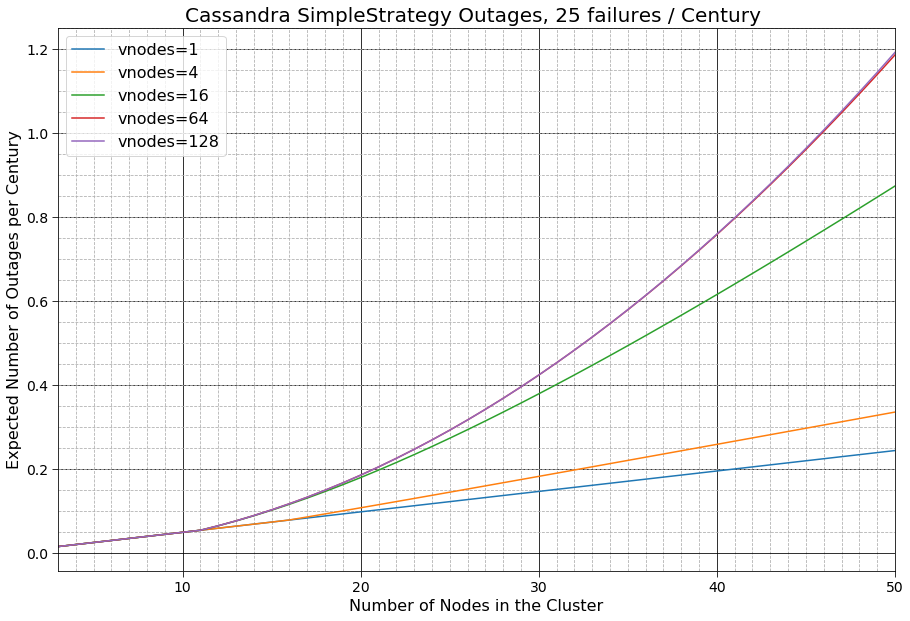

In [5]:
# Hold failures constant, vary size of cluster
plt.figure(figsize=(15,10))
plt.title(
    "Cassandra SimpleStrategy Outages, {0} failures / Century ".format(
        arate), fontsize=20)
plt.ylabel("Expected Number of Outages per Century", fontsize=16)
plt.xlabel("Number of Nodes in the Cluster", fontsize=16)
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(4))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(10))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)

num_vnodes = (1, 4, 16, 64, 128)
num_nodes = range(3, 51)
for v in num_vnodes:
    outages = [compute_outage(v, arate, n, rf, bw_in, bw_out, 'simple') for n in num_nodes]
    print(v, outages[:3])
    plt.plot(num_nodes, outages, label="vnodes={0}".format(v))

plt.xlim(3, 50)
plt.legend(fontsize=16)

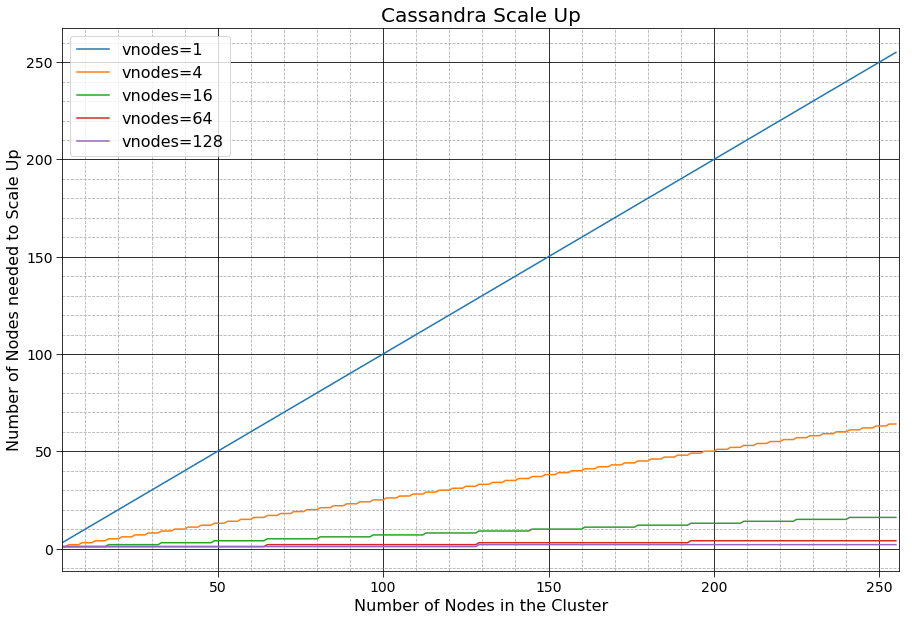

In [6]:
# Observe impact of vnodes on Scale Up Balancing 
plt.figure(figsize=(15,10))
plt.title("Cassandra Scale Up",fontsize=20)
plt.ylabel("Number of Nodes needed to Scale Up", fontsize=16)
plt.xlabel("Number of Nodes in the Cluster", fontsize=16)
plt.gca().grid(True, which='major', linestyle='-', color='k')
plt.gca().grid(True, which='minor', linestyle='--')
plt.gca().yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.gca().xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(5))
plt.tick_params(axis='both', which='major', labelsize=14, length=6)
plt.tick_params(axis='both', which='minor', length=0)

num_vnodes = (1, 4, 16, 64, 128)
num_nodes = range(3, 256)
for v in num_vnodes:
    scale_up = [math.ceil(float(n) / v) for n in num_nodes]
    plt.plot(num_nodes, scale_up, label="vnodes={0}".format(v))

plt.xlim(3, 256)

plt.legend(fontsize=16)

In [7]:
import itertools
import random
import sys

def simulate(l):
    return random.expovariate(l)

def offset(values, max_value=float("inf")):
    nvalues = values[:1] + [0] * (len(values) - 1)
    for i in range(1,len(values)):
        nvalues[i] = values[i] + nvalues[i-1]
    return [n for n in nvalues if n <= max_value]

def outage(o, f_i, t, neighbors):
    failures = 0
    neighbor_indices = range(0, len(o))
    neighbor_indices.remove(f_i)
    random.shuffle(neighbor_indices)
    for n in range(int(round(neighbors))):
        failures += near(o[neighbor_indices[n]], o[f_i], t)
    return failures

def near(a, b, t):
    failures = 0
    for i in a:
        for j in b:
            if j > i + t:
                break
            if j - i > 0 and j - i < t:
                failures += 1
    return failures

def run_simulate(l, neighbors, nodes):
    rs = []
    for r in range(5):
        o = [offset([simulate(l) for j in range(300)]) for i in range(nodes)]
        maxes = [x[-1] for x in o]
        m = max(maxes)
        outages_per_century = (
            sum([outage(o, i, arecovery / century_seconds, neighbors) for i in range(nodes)]) /
            m
        )
        print("Run {0} gave {1:.3f} outages/century".format(r, outages_per_century))
        rs.append(outages_per_century)
    print("Simulation outages/century: ", sum(rs) / len(rs))
    
def run_simulate_naive(l, neighbors, nodes):
    p_split = p_outage_given_failure(arecovery, aneighbors, l / century_seconds)
    l_split = l * p_split
    l_global = nodes * l_split
    print(p_split, l_global)
    rs = []
    for r in range(10):
        events = 1000
        o = offset([simulate(l_global) for j in range(events)])
        ##failure_years = [int(x/year) for x in o]
        num_centuries = max(o)
        rs.append(events / num_centuries)
    print("Simple simulation outages/century: ", sum(rs) / len(rs))    
    
    
print(p_outage_given_failure(arecovery, num_neighbors(nodes, vnodes, rf), arate))
print(vnodes, arate, nodes, rf, bw_in, bw_out, arecovery, num_neighbors(nodes, vnodes, rf))
print("Predicted outages/century:", compute_outage(vnodes, arate, nodes, rf, bw_in, bw_out))
#run_simulate(arate, num_neighbors(nodes, vnodes, rf), nodes)
run_simulate_naive(arate, num_neighbors(nodes, vnodes, rf), nodes)
#run_simulate(arate, num_neighbors(nodes, vnodes, rf), nodes)

1.0
256 25 96 3 125 12.5 2457 63.999993652404335
Predicted outages/century: 2.98991656006
0.001245798566692824 2.9899165600627775
Simple simulation outages/century:  3.014446865816492
